In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

In [2]:
d=pd.read_csv('heart_failure_clinical_records_dataset.csv')
data=d.to_numpy()
n=data.shape[0]
X=np.ones(n)
X=X.reshape(-1,1)
X=np.concatenate((X,data[:,:-1]),axis=1)
Y=data[:,-1]
Y=Y.reshape(-1,1)


In [3]:
class RMSprop:
    def __init__(self, lr=0.001,beta=0.9, eps=1e-6):
        self.alpha = lr
        self.beta = beta
        self.eps = eps
        self.v = 0
    
    def apply_grads(self, W, grad_W):
        self.v=self.beta * self.v + (1 - self.beta) * grad_W**2
        W = W - self.alpha * grad_W / (self.eps + self.v) ** 0.5 
        return W

In [65]:
class Log_reg:
    def __init__(self, num_features=1, optimizer=RMSprop(1e-5), alpha=0):
        self.W = np.zeros((num_features, 1))
        self.optimizer=optimizer
        self.alpha=alpha
    
    def sigma(self, x):
        return 1/(1+np.exp(-x))
    
    def predict_proba(self, X):
        y = self.sigma(X @ self.W)
        return y
    
    def predict(self, X):
        return np.floor(self.predict_proba(X)+0.5)
    
    def one_step_opt(self, X, y_true):
        grad_reg = 2 * self.alpha * self.W
        grad_reg[0, 0] = 0
        grads = 2*X.T@(self.predict_proba(X)-y_true)/X.shape[0]+grad_reg
        self.W = self.optimizer.apply_grads(self.W, grads)
        hy=self.predict_proba(X)
        loss = np.mean(-y_true * np.log(hy) + (y_true-1) * np.log(1 - hy))
        return np.squeeze(loss), grads
    
    def fit(self, X, y_true, B=-1, grad_tol=1e-6, n_iters=1000):
        n=X.shape[0]
        grad_norm = np.inf
        n_iter = 0
        losses=[]
        losses_changes=[]
        hy=self.predict_proba(X)
        loss = np.mean(-y_true * np.log(hy) + (y_true-1) * np.log(1 - hy))
        last_10_losses=np.array([loss]*int(np.ceil(np.log(n)*np.sqrt(n))))
        batches=np.array([])
        itr=-1
        rng=np.arange(n)
        while (grad_norm > grad_tol) and (n_iter < n_iters):
            if B==-1 or B>=n:
                loss, grads=self.one_step_opt(X,y_true)
            else:
                if itr==-1:
                    np.random.shuffle(rng)
                    batches=rng[:(n//B)*B].reshape(-1,B)
                    itr=batches.shape[0]-1
                    
                mini_batch=batches[itr]
                itr-=1
                
                loss, grads=self.one_step_opt(X[mini_batch],y_true[mini_batch])
            grad_norm=np.linalg.norm(grads)
            n_iter += 1
            last_10_losses=np.append(last_10_losses, loss)[1:]
            losses_changes.append(np.mean(last_10_losses))
            losses.append(loss)
        return losses, losses_changes

In [66]:
LR=Log_reg(X.shape[1],optimizer=RMSprop(5e-6),alpha=0)
losses,losses_changes=LR.fit(X,Y,B=32,n_iters=500000)
y_pred=LR.predict_proba(X)

In [70]:
print(np.sum((y_pred>0.5)==Y)/X.shape[0])

0.802675585284281


Ratio of correct answers to the number of tests onb train dataset

In [71]:
def mean_std(X):             #mean-std normaliation
    res=X-np.mean(X, axis=0)
    res=res/np.std(X,axis=0)
    return res

In [72]:
X_norm=mean_std(X[:,1:])

In [73]:
X_norm=np.concatenate((np.ones(X_norm.shape[0]).reshape(-1,1),X_norm),axis=1)

In [74]:
LR_norm=Log_reg(X_norm.shape[1],optimizer=RMSprop(5e-6),alpha=0)
losses_norm,losses_changes_norm=LR_norm.fit(X_norm,Y,B=32,n_iters=500000)
y_pred_norm=LR_norm.predict_proba(X_norm)

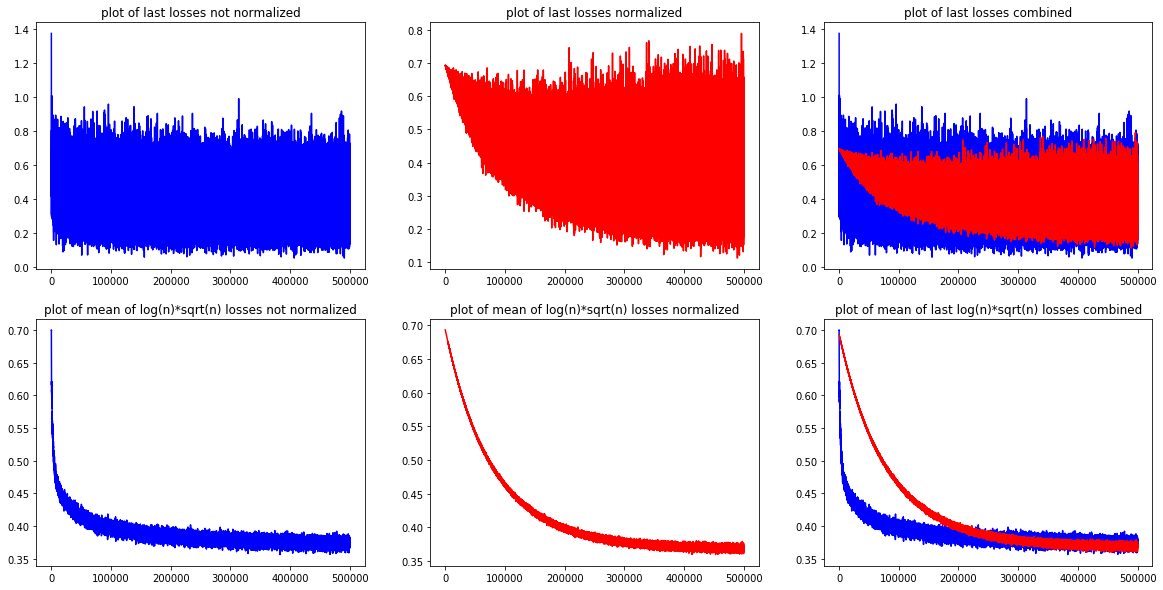

In [75]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
plt.plot(losses[:],color='blue')
plt.title(f'plot of last losses not normalized')
plt.subplot(2, 3, 2)
plt.plot(losses_norm[:],color='red')
plt.title(f'plot of last losses normalized')
plt.subplot(2, 3, 4)
plt.plot(losses_changes[:],color='blue')
plt.title(f'plot of mean of log(n)*sqrt(n) losses not normalized')
plt.subplot(2, 3, 5)
plt.plot(losses_changes_norm[:],color='red')
plt.title(f'plot of mean of log(n)*sqrt(n) losses normalized')
plt.subplot(2, 3, 3)
plt.plot(losses[:],color='blue')
plt.plot(losses_norm[:],color='red')
plt.title(f'plot of last losses combined')
plt.subplot(2, 3, 6)
plt.plot(losses_changes[:],color='blue')
plt.plot(losses_changes_norm[:],color='red')
plt.title(f'plot of mean of last log(n)*sqrt(n) losses combined')
plt.show()

In [76]:
np.sum(((y_pred_norm>0.5)==Y)/X.shape[0])

0.8528428093645486

Ratio of correct answers to the number of tests on normalised data on train dataset

The loss graphs were not very demonstrative, so I decided to plot graphs of mean losses on last $\lceil log(n)*\sqrt n  \rceil$ steps of model treaning, where n-is total number of steps. This graph gives more understandable results.

In [79]:
def k_fold(data,Y,model,K=5,optimizer=RMSprop(5e-6),alpha=0,B=32,n_iters=500000):       #k-fold Cross-Validation
    n=data.shape[0]
    k=n//K
    correct_anss=0
    for i in range(K):
        LR=model(data.shape[1],optimizer=optimizer,alpha=alpha)
        LR.fit(np.concatenate((data[:i*k,:],data[(i+1)*k+1:,:])),np.concatenate((Y[:i*k,:],Y[(i+1)*k+1:,:])),B=B,n_iters=n_iters)
        y_pred=LR.predict_proba(data[i*k:(i+1)*k,:])
        correct_anss+=np.sum((y_pred>0.5)==Y[i*k:(i+1)*k,:])
    return correct_anss/n

In [80]:
accuracy=k_fold(X_norm,Y,Log_reg)
accuracy

0.7591973244147158

Ratio of correct answers on test dataset

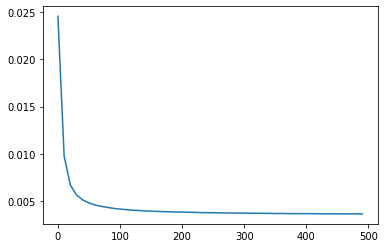

In [81]:
alphas=np.arange(0,500,10)
weights=np.array([])
for i in alphas:
    LR=Log_reg(X_norm.shape[0])
    LR=Log_reg(X_norm.shape[1],optimizer=RMSprop(5e-6),alpha=i)
    LR.fit(X_norm,Y,B=32,n_iters=10000)
    weights=np.append(weights,np.mean(np.abs(LR.W)))
plt.plot(alphas,weights)
plt.show()

Mean weights of models depending on L2 regularisation parameter

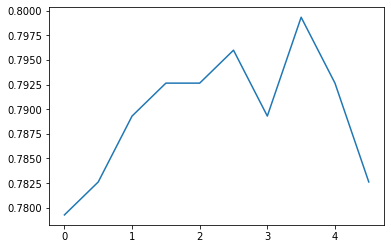

In [82]:
alphas=np.arange(0,5,0.5)
accuracyes=np.array([])
for i in alphas:
    accuracy=k_fold(X_norm,Y,Log_reg,n_iters=10000,alpha=i)
    accuracyes=np.append(accuracyes,accuracy)
plt.plot(alphas,accuracyes)
plt.show()

Best result is in the area of $\alpha=3.5$

Now I will choice best learning rate

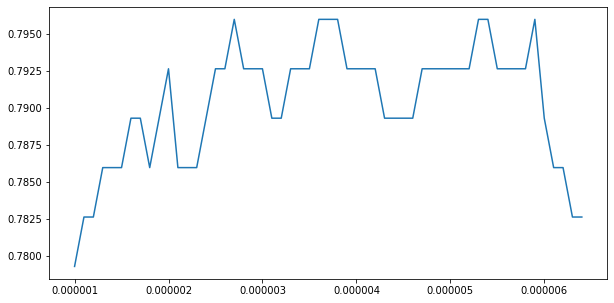

0.7959866220735786 2.7000000000000017e-06


In [90]:
plt.figure(figsize=(10, 5))
lrs=np.arange(1e-6,6.5e-6,1e-7)
accuracyes=np.array([])
for i in lrs:
    accuracy=k_fold(X_norm,Y,Log_reg,n_iters=10000,alpha=3.5, optimizer=RMSprop(i))
    accuracyes=np.append(accuracyes,accuracy)
plt.plot(lrs,accuracyes)
plt.show()
print(np.max(accuracyes), lrs[np.argmax(accuracyes)])

The most successful lr one turned out to be around 2.7e-6 

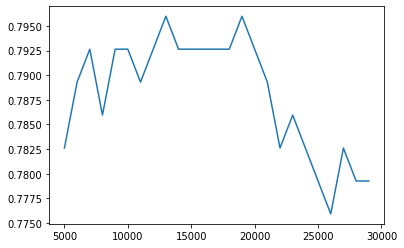

0.7959866220735786 13000


In [92]:
iterations=np.arange(5000,30000,1000)
accuracyes=np.array([])
for i in iterations:
    accuracy=k_fold(X_norm,Y,Log_reg,n_iters=i,alpha=3.7, optimizer=RMSprop(2.7e-6))
    accuracyes=np.append(accuracyes,accuracy)
plt.plot(iterations,accuracyes)
plt.show()
print(np.max(accuracyes), iterations[np.argmax(accuracyes)])

On 13000 iterations I got maximum accuracy $(\approx0.796)$

So, with chosing metadata I got model with around 4% hugher accuracy. And as a result I created model with almost 80% accuracy.